In [1]:
#!pip uninstall tensorflow

In [2]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
from tensorflow.compat.v1 import enable_eager_execution
import tensorflow as tf
import numpy as np
import os
import tensorflow_probability as tfp
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skopt import gp_minimize #貝氏優化
from skopt.space import Real, Integer
from skopt.utils import use_named_args

print(tf.__version__)

2.0.0


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

## 匯入資料（MNIST）

## 參數設定

In [3]:
img_size = 28
flatten_size = img_size * img_size 

regular = 1e-5

z_dim = 32
h_dim = [8, 4]
objective = 'deep-SVDD'     #'  'soft-boundary'


## 建構模型

## Prtrain

In [4]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = 28, z_dim = 32, h_dim = [8, 4]):
        
        self.label_num = label_num
        self.img_size = img_size
        self.flatten_size = img_size * img_size
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.5e-3)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, self.img_size, self.img_size, 1))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)    
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.keras.layers.Dense(self.h_dim[1] * 7 * 7,  use_bias = False)(inputs)
        x = tf.reshape(x, shape = (-1, 7, 7, self.h_dim[1]))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 

        x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)

        x = tf.reshape(x, shape = (-1, self.flatten_size))
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model   
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset, ae_lr_milestone = 50):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % ae_lr_milestone == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoint/mnist_classAE_label_{}' .format(
            self.label_num))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        

## 匯入資料

In [5]:
def load_data(label_num, outlier_nu):

    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') /255.
    x_test = x_test.astype('float32') /255.
    
    random.seed (1120)
    normal_n = sum(y_train == label_num)
    outlier_n = sum(y_train != label_num)
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    
    x_train = np.vstack( (x_train[y_train==label_num], x_train[y_train!=label_num][indices]))
    y_train = np.hstack( (y_train[y_train==label_num], y_train[y_train!=label_num][indices]))

    # Flatten the dataset
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))


    return  x_train, y_train, x_test, y_test

In [6]:
def split_data(x_train, y_train, batch_size = 200):
    x_novali, x_vali, y_novali, y_vali = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
    
    
    n_samples = len(x_novali)
    train_dataset = tf.data.Dataset.from_tensor_slices(x_novali)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    
    validation_n = len(x_vali)
    
    return train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n

## result 

In [7]:
def threshold_img(data, dists):
    dict_score = {}
    for i in range(len(dists)):
        dict_score[float(dists[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [8]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [9]:
def false_img(data, y_test,  dists, r, label_num):
    data_n = data[y_test!=label_num]
    data_p = data[y_test==label_num]
    
    dist_n = (dists - r**2)[y_test!=label_num]
    dist_p = (dists - r**2)[y_test==label_num]
    
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    n_digits = min([len(fn),len(fp),10])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display fn
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display fp
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
def distance_plot(label_num, dist, radius_end, objective, name, train = True, label = None,  nu = 0.1):
    treshold = radius_end ** 2
    if train:
        plt.title(str(objective) + ' label = {} train data'.format(name))
        if objective == 'soft-boundary':
            treshold = 0
            plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            if sum(label!=label_num):
                plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
                plt.axvline(treshold,  color='g')
                plt.legend()
        else:
            plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            if sum(label!=label_num):
                plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
                plt.axvline(treshold,  color='g')
                plt.legend()
        plt.show()       
    
    else:
        plt.title(str(objective) + ' label = {} test data'.format(name))
        if objective == 'soft-boundary':
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dist[label==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
            plt.axvline(treshold,  color='g')
            plt.legend()

        else:
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dist[label==label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            plt.axvline(float(treshold), color='g')
            plt.legend()

        plt.legend()
        plt.show()
    


In [11]:
class train_SVDD():
    
    def __init__(self, label_num , objective , encoder, train_dataset, nu = 0.2, z_dim = 32):
        
        self.objective = objective
        self.nu = nu
        self.z_dim = z_dim
        self.encoder = encoder
        self.label_num = label_num
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3, epsilon = 1e-6)
        self.train_dataset = train_dataset
        self.center = self.init_center_c( eps = 0.1)
        if self.objective == 'soft-boundary':
            self.R = tf.zeros(shape = [1], dtype = tf.float32, name = 'R')
        else:
            self.R = None
        
        
    def init_center_c(self, eps = 0.1):
        
        self.encoder.load_weights('D:/7107018014/checkpoint/mnist_classAE_label_{}' .format(
            self.label_num))
        positive = tf.fill([self.z_dim], eps)
        negative = tf.fill([self.z_dim], -eps)
        c = tf.zeros(shape = [self.z_dim], dtype = tf.float32, name = 'c')
        
        for batch, (batch_x) in enumerate(self.train_dataset):
            output = self.encoder(batch_x, training=False)            
            if batch ==0:
                modeloutput = output
            else:
                modeloutput = tf.concat([modeloutput, output], 0)
        
        c = tf.reduce_mean(modeloutput, axis = 0, name = 'outputs')
        #c = tf.reduce_mean( self.encoder(data, training = False), axis = 0, name = 'outputs') 

        c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
        c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
        
        return c
        
    def get_radius(self,dist, nu):
        """Optimally solve for radius R via the (1-nu)-quantile of distances."""
        return tfp.stats.percentile(tf.sqrt(dist), (1-self.nu)*100)

    def loss(self, objective, dist, R = None):

        if objective == 'soft-boundary':
            scores = dist - R**2
            avg_loss = R**2 + (1/nu) * tf.reduce_mean(tf.maximum(tf.zeros_like(scores), scores))

        if objective=='deep-SVDD':
            avg_loss = tf.reduce_mean(dist)
        return avg_loss

    @tf.function
    def train_model(self, batch_x, center, objective, R = None):
        with tf.GradientTape() as tape:
            output = self.encoder(batch_x, training=True)
            dist = tf.reduce_sum((output - self.center) ** 2, axis=1)
            output_loss = self.loss(self.objective, dist, R)

        grads = tape.gradient(output_loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables))

        return output_loss, dist
    def train(self, x_novali, n_epochs = 150, warm_up_n_epochs = 10, lr_milestone = 50):
        
        loss_list = []
        for epoch in range(n_epochs):
            epoch_loss_avg = tf.metrics.Mean()
            if (epoch+1) % lr_milestone == 0:
                self.optimizer.lr = 0.1 * self.optimizer.lr

            for batch, (batch_x) in enumerate( self.train_dataset):
                loss_, dist = self.train_model(batch_x, self.center, self.objective, self.R )
                epoch_loss_avg(loss_)
                if (self.objective == 'soft-boundary') and (epoch >= warm_up_n_epochs):
                    self.R = self.get_radius(dist, nu)
            loss_list.append(loss_)
        self.encoder.save_weights('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Model_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_num, self.nu))
        if (self.objective == 'soft-boundary'):
            np.save('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Radius_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_num, self.nu), self.R.numpy())
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        
    def distance(self, data, load_model = False):
        if load_model:
            self.encoder.load_weights('D:/7107018014/checkpoint/Model_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_num, self.nu))
            self.R = np.load('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Radius_{}_label_{}_outlier_{}.npy' .format
                                  (self.objective, self.label_num, self.nu))
        output = self.encoder(tf.convert_to_tensor(data), training=False)
        dist = tf.reduce_sum(tf.math.square(output - self.center) , axis=1) ## dist**2
        
        return dist
    
    def decide_treshold(self, x_novali):
        
        if self.objective == 'soft-boundary':
            self.R = np.load('D:/7107018014/checkpoint/one-class SVDD_trainoutlier/Radius_{}_label_{}_outlier_{}.npy' .format
                                  (self.objective, self.label_num, self.nu))
            radius_end = self.R
        else:
            dis = self.distance(tf.convert_to_tensor(x_novali))
            radius_end = self.get_radius(dis, self.nu).numpy()
            
        return float(radius_end)
    
    def train_result(self, x_novali, y_novali, show_img = False, load_model = False):
        
        radius_end = self.decide_treshold(x_novali)
        test_auc = 0.
        confusionmatrix = 0.
        if show_img:
            dist = self.distance(x_novali, load_model = load_model).numpy()
            test_auc, confusionmatrix = self.result(dist, y_novali, radius_end, show_img = show_img)
            distance_plot(self.label_num, dist, radius_end, self.objective, name =  self.label_num,
                          train = True, label = y_novali, nu = self.nu )
            print(' train label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_novali, dist, radius_end)
            print('train label = {} distance oder'.format(self.label_num))
            threshold_img(x_train, dist)
            print('train label = {} false_img'.format(self.label_num))
            false_img(x_novali, y_novali,  dist, radius_end, self.label_num)
            
        return radius_end, test_auc, confusionmatrix
    
    def result(self, dist, y_test, radius_end, show_img = False):
        
        y_true = y_test==self.label_num
        scores = dist - radius_end ** 2
        y_prob = 1/dist
        test_auc = roc_auc_score(y_true, y_prob)
        confusionmatrix = confusion_matrix(y_true, scores<0)
        if show_img:
            print('AUC:', test_auc)
            print('confusion_matrix:')
            print(confusionmatrix)

        return test_auc, confusionmatrix 
    
    def test(self, x_test, y_test, radius_end, show_img = False, load_model = False, search_u = False):
        
        dist = self.distance(x_test, load_model = load_model).numpy()
        test_auc, confusionmatrix = self.result(dist, y_test, radius_end, show_img = show_img)
        if show_img:
            distance_plot(self.label_num, dist, radius_end, self.objective, name =  self.label_num,
                          train = False, label = y_test, nu = self.nu )
            print('test label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_test, dist, radius_end)
            print('test label = {} distance oder'.format(self.label_num))
            threshold_img(x_test, dist)
            print('test label = {} false_img'.format(self.label_num))
            false_img(x_test, y_test,  dist, radius_end, self.label_num)
        if search_u:
            print('u = {}, auc = {}'.format(self.nu, test_auc))
        return test_auc, confusionmatrix 

## 看時間的結果

In [12]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [13]:
objective = 'soft-boundary'
nu = 0.05
outlier_nu = 0.05
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print(label_num,'  auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)

0   auc =  0.8732530883750395
1   auc =  0.977488663779502
2   auc =  0.7307453849691237
3   auc =  0.8263703344750494
4   auc =  0.8026630603920017
5   auc =  0.7641620189022216
6   auc =  0.8449443654040366
7   auc =  0.8701435594699289
8   auc =  0.8057787996438307
9   auc =  0.8941932792830272


In [14]:
result

array([[ 0.        ,  0.        ,  0.87325309, 61.40904617],
       [ 1.        ,  0.        ,  0.97748866, 69.71654415],
       [ 2.        ,  0.        ,  0.73074538, 72.31942177],
       [ 3.        ,  0.        ,  0.82637033, 70.83283687],
       [ 4.        ,  0.        ,  0.80266306, 68.57406759],
       [ 5.        ,  0.        ,  0.76416202, 68.83124828],
       [ 6.        ,  0.        ,  0.84494437, 67.58386374],
       [ 7.        ,  0.        ,  0.87014356, 74.46940994],
       [ 8.        ,  0.        ,  0.8057788 , 67.93004632],
       [ 9.        ,  0.        ,  0.89419328, 70.13147259]])

AUC: 0.8422083498247201
confusion_matrix:
[[ 239    0]
 [4736    0]]


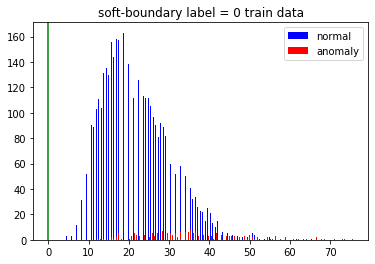

 train label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 0 distance oder


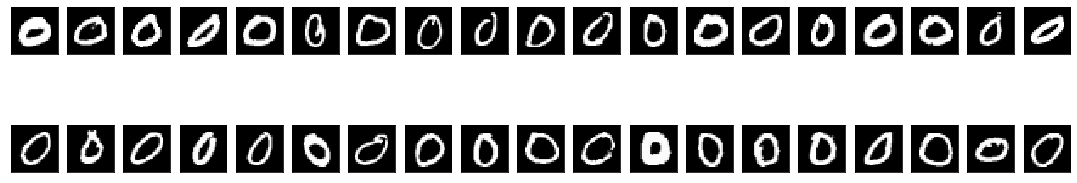

train label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8295795058599936
confusion_matrix:
[[9020    0]
 [ 980    0]]


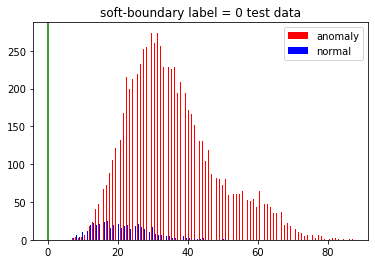

test label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 0 distance oder


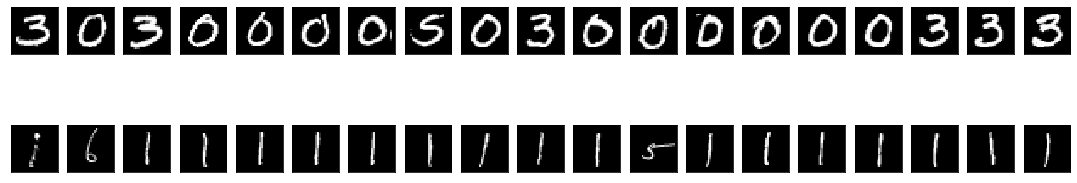

test label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8917413157318697
confusion_matrix:
[[ 264    0]
 [5399    0]]


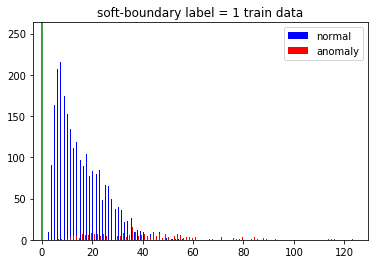

 train label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 1 distance oder


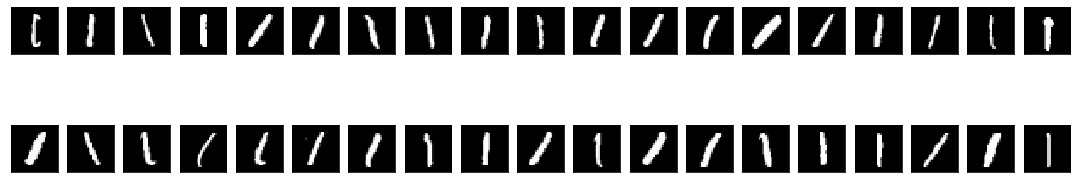

train label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.9071076425382202
confusion_matrix:
[[8865    0]
 [1135    0]]


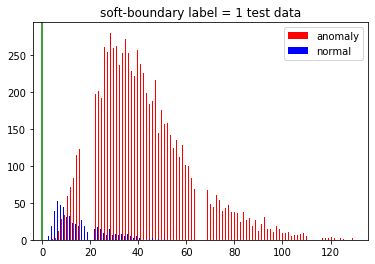

test label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 1 distance oder


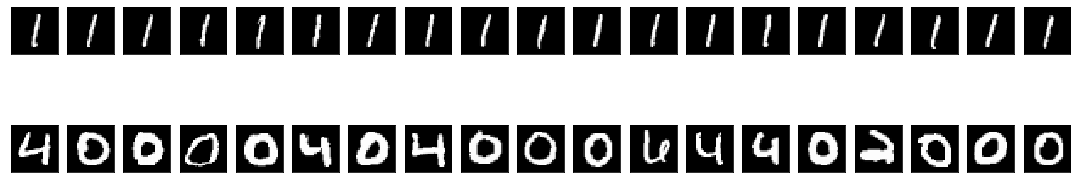

test label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7511402251293817
confusion_matrix:
[[ 242    0]
 [4762    0]]


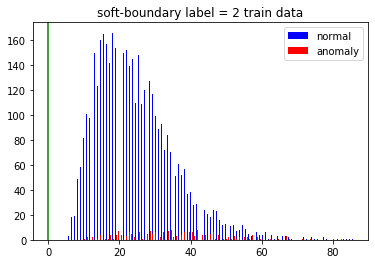

 train label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 2 distance oder


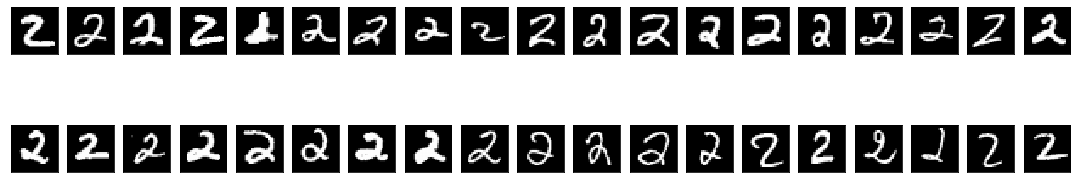

train label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7525499796001632
confusion_matrix:
[[8968    0]
 [1032    0]]


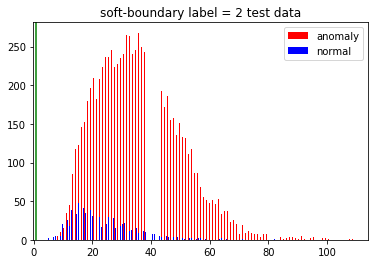

test label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 2 distance oder


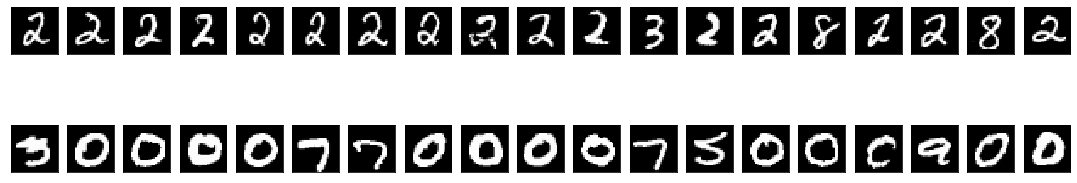

test label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7714233363014845
confusion_matrix:
[[ 246    0]
 [4903    0]]


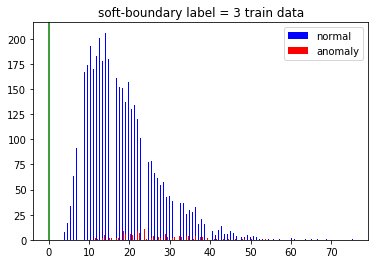

 train label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 3 distance oder


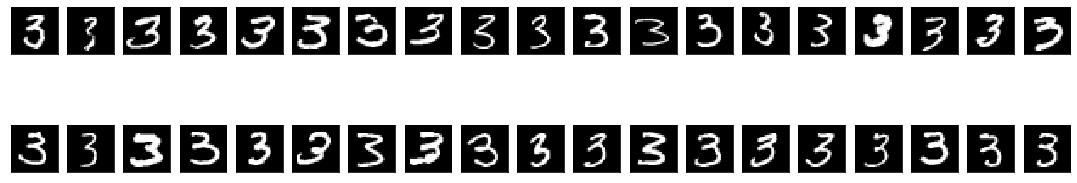

train label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7704432868203394
confusion_matrix:
[[8990    0]
 [1010    0]]


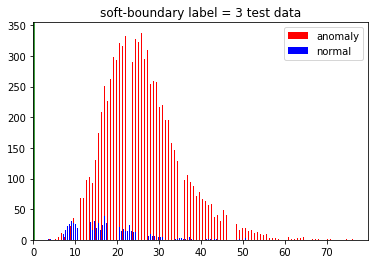

test label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 3 distance oder


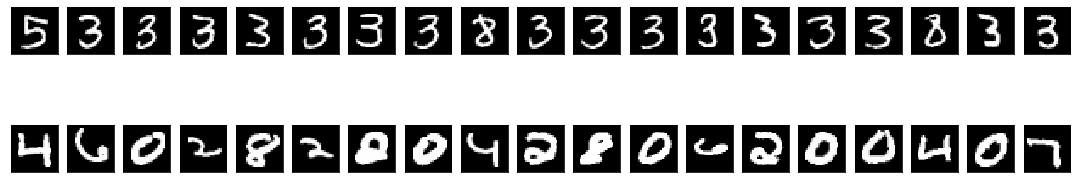

test label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7249188491227009
confusion_matrix:
[[ 226    0]
 [4681    0]]


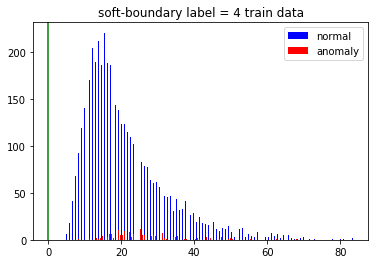

 train label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 4 distance oder


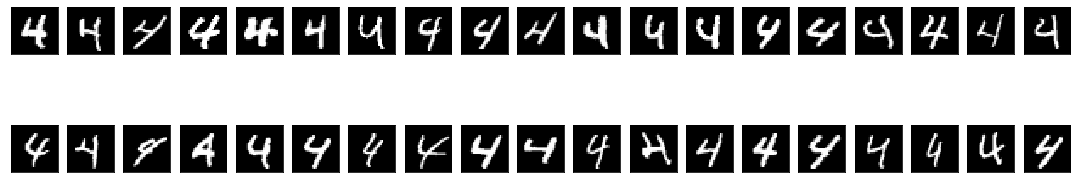

train label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7169570679866789
confusion_matrix:
[[9018    0]
 [ 982    0]]


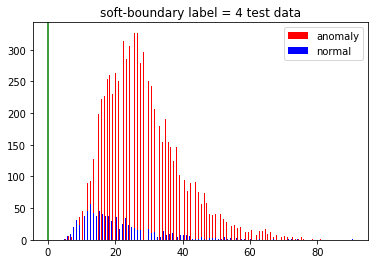

test label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 4 distance oder


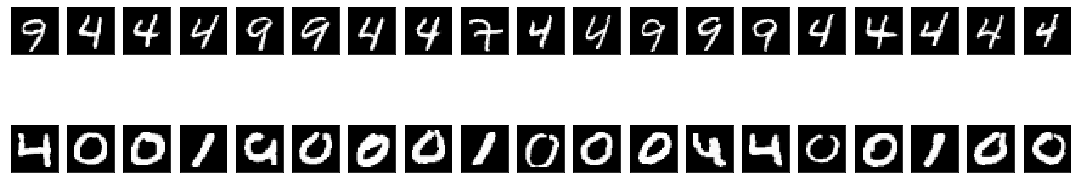

test label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.6199984695699492
confusion_matrix:
[[ 217    0]
 [4336    0]]


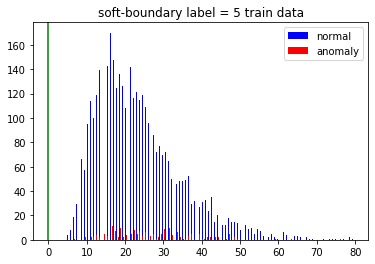

 train label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 5 distance oder


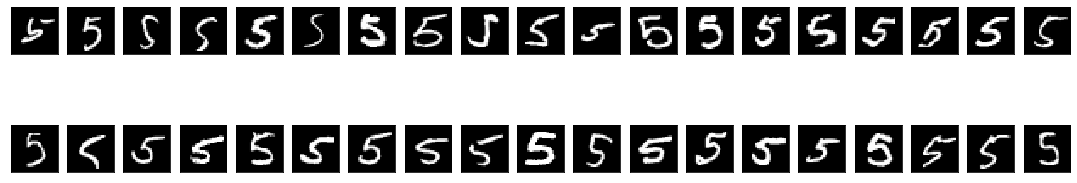

train label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5973345390934102
confusion_matrix:
[[9108    0]
 [ 892    0]]


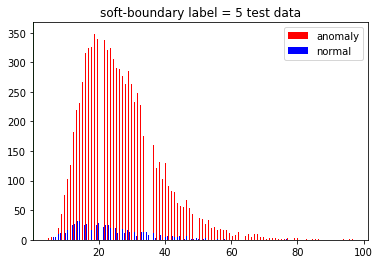

test label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 5 distance oder


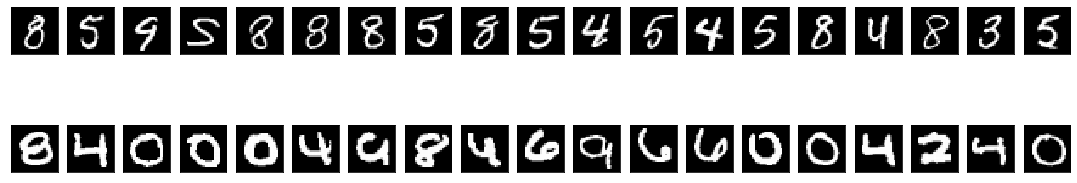

test label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7475381441779292
confusion_matrix:
[[ 241    0]
 [4729    0]]


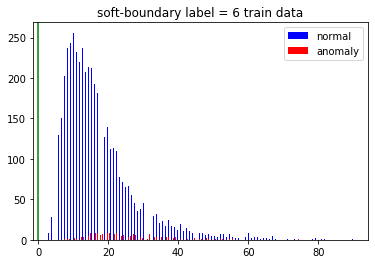

 train label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 6 distance oder


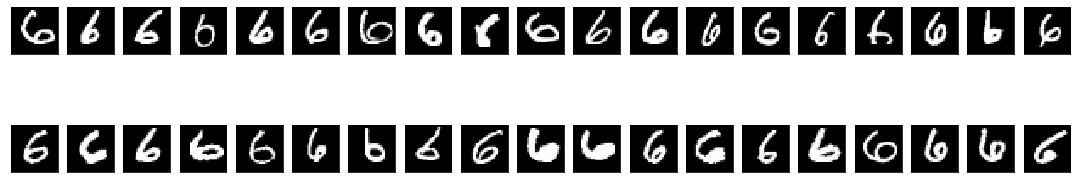

train label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.6798448460651498
confusion_matrix:
[[9042    0]
 [ 958    0]]


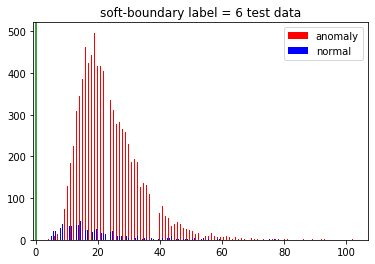

test label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 6 distance oder


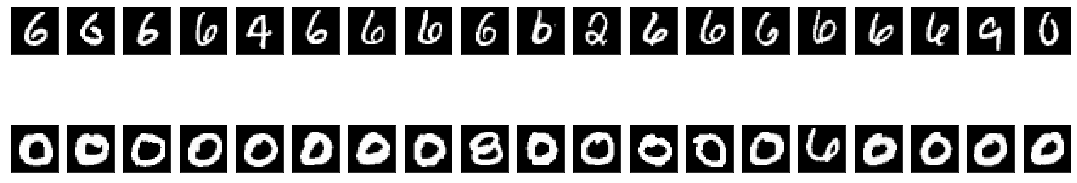

test label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7936629894618124
confusion_matrix:
[[ 255    0]
 [5007    0]]


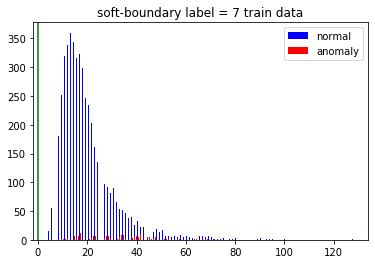

 train label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 7 distance oder


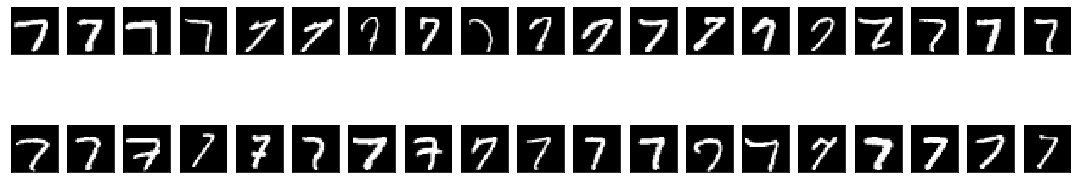

train label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7808102943702068
confusion_matrix:
[[8972    0]
 [1028    0]]


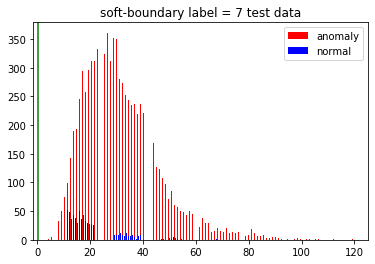

test label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 7 distance oder


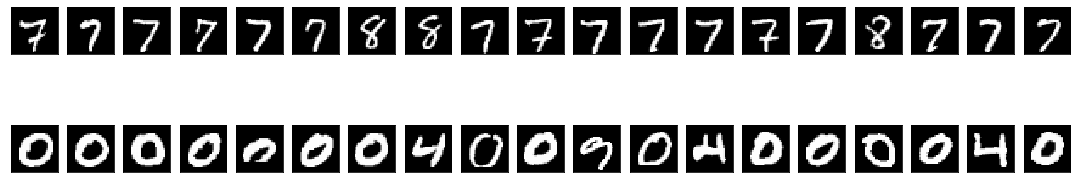

test label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7727274777639747
confusion_matrix:
[[ 237    0]
 [4677    0]]


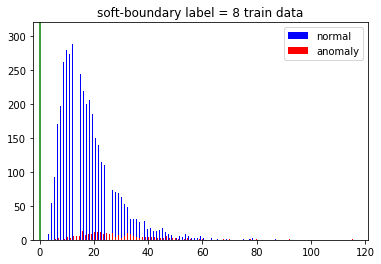

 train label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 8 distance oder


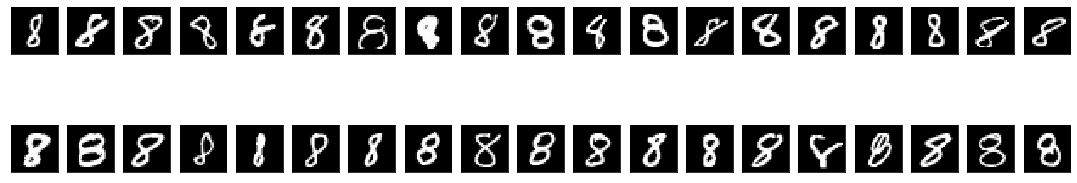

train label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7579784910668746
confusion_matrix:
[[9026    0]
 [ 974    0]]


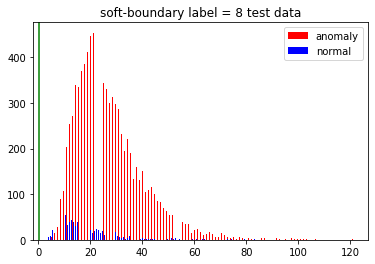

test label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 8 distance oder


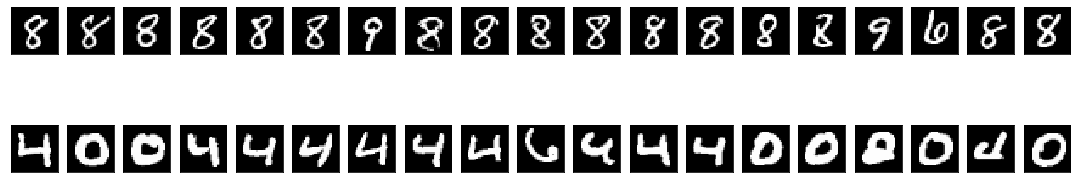

test label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7798023610990473
confusion_matrix:
[[ 232    0]
 [4764    0]]


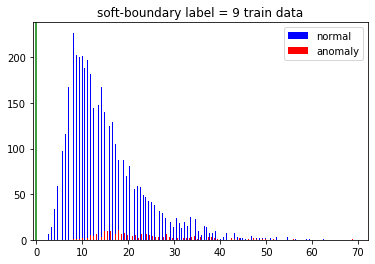

 train label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 9 distance oder


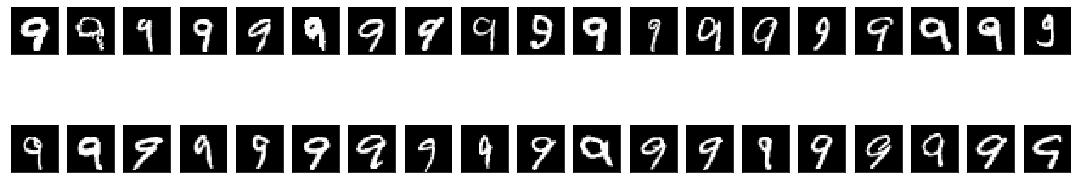

train label = 9 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7855432240962469
confusion_matrix:
[[8991    0]
 [1009    0]]


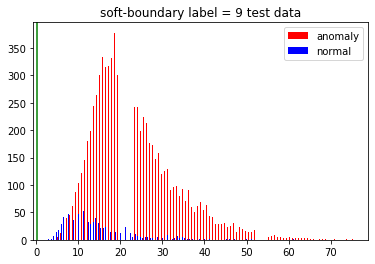

test label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 9 distance oder


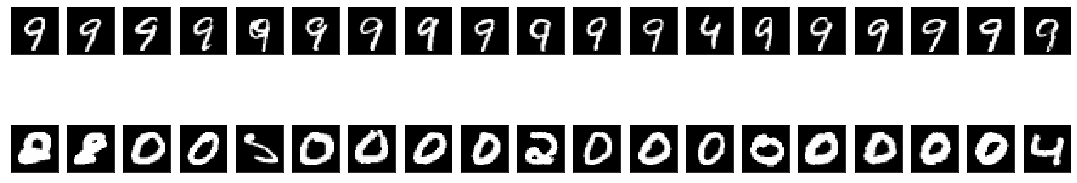

test label = 9 false_img


<Figure size 1440x288 with 0 Axes>

In [15]:
objective = 'soft-boundary'
nu = 0.05
outlier_nu = 0.05
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)



In [16]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [17]:
objective = 'soft-boundary'
nu = 0.1
outlier_nu = 0.1
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)

auc =  0.8442806235576271
auc =  0.9623571387752161
auc =  0.7157309213983915
auc =  0.7320157710988006
auc =  0.8027601732493376
auc =  0.7508238211713548
auc =  0.8500403360056225
auc =  0.8244525553776471
auc =  0.7428865094722934
auc =  0.8699606996050119


In [18]:
result

array([[ 0.        ,  0.        ,  0.84428062, 73.13687611],
       [ 1.        ,  0.        ,  0.96235714, 79.31696534],
       [ 2.        ,  0.        ,  0.71573092, 75.08399487],
       [ 3.        ,  0.        ,  0.73201577, 73.37335229],
       [ 4.        ,  0.        ,  0.80276017, 72.68756557],
       [ 5.        ,  0.        ,  0.75082382, 65.84878969],
       [ 6.        ,  0.        ,  0.85004034, 73.10053086],
       [ 7.        ,  0.        ,  0.82445256, 75.35110617],
       [ 8.        ,  0.        ,  0.74288651, 71.53493762],
       [ 9.        ,  0.        ,  0.8699607 , 69.97916651]])

AUC: 0.8850506827620925
confusion_matrix:
[[ 484    0]
 [4728    0]]


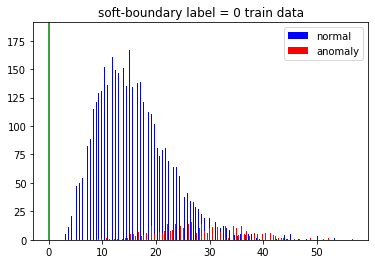

 train label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 0 distance oder


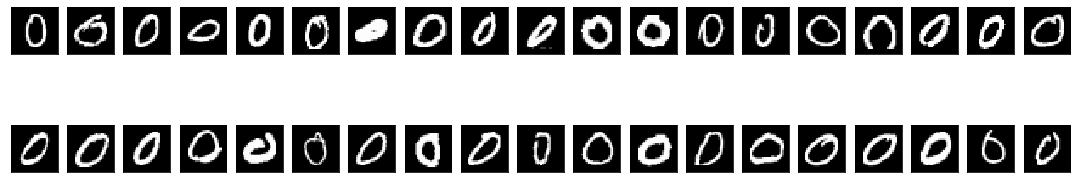

train label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8884998189963346
confusion_matrix:
[[9020    0]
 [ 980    0]]


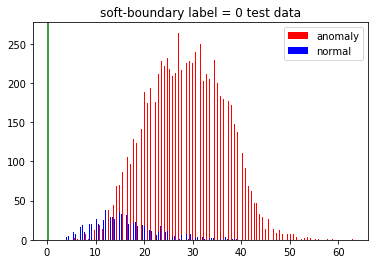

test label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 0 distance oder


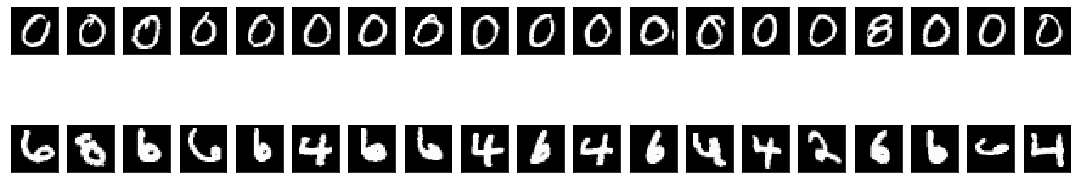

test label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8899625160937796
confusion_matrix:
[[ 554    0]
 [5378    0]]


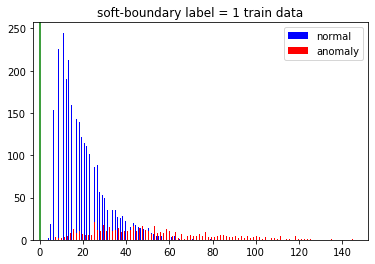

 train label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 1 distance oder


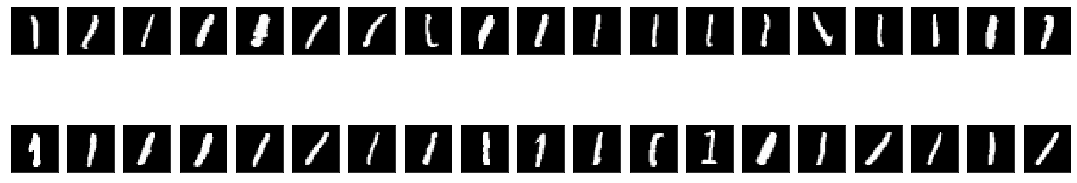

train label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8942753142462438
confusion_matrix:
[[8865    0]
 [1135    0]]


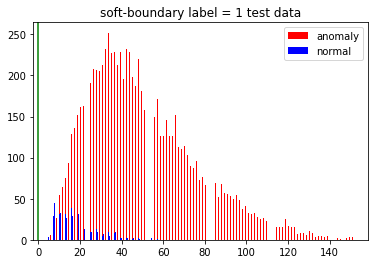

test label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 1 distance oder


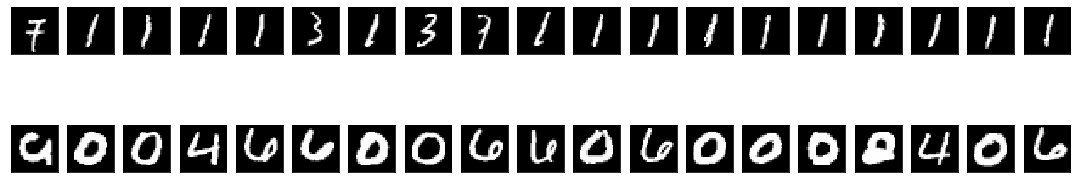

test label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7194914985097431
confusion_matrix:
[[ 483    0]
 [4759    0]]


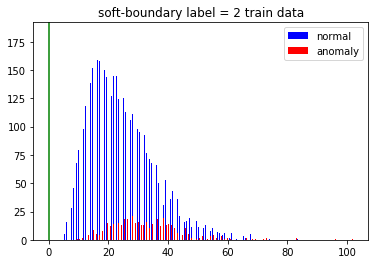

 train label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 2 distance oder


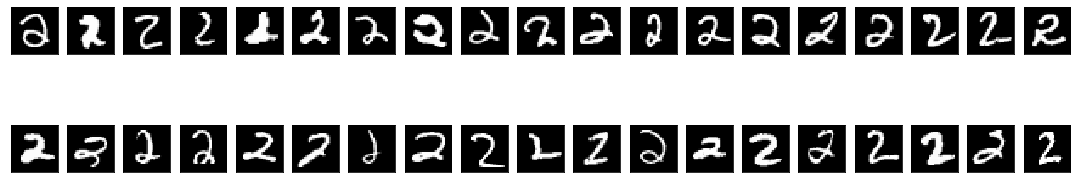

train label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7253226804694037
confusion_matrix:
[[8968    0]
 [1032    0]]


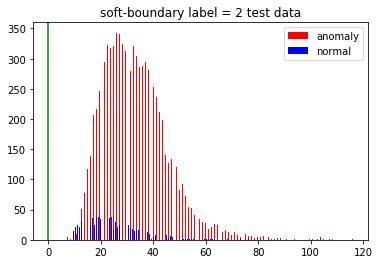

test label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 2 distance oder


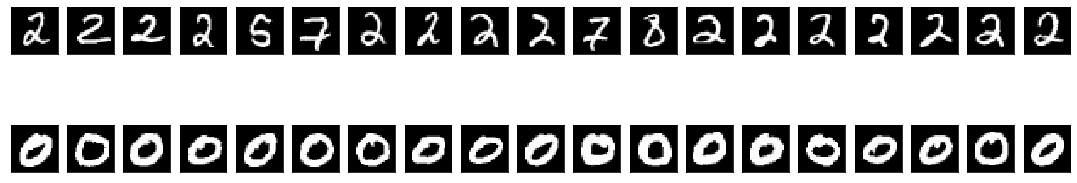

test label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7478375893769152
confusion_matrix:
[[ 500    0]
 [4895    0]]


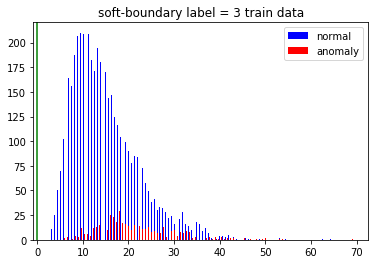

 train label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 3 distance oder


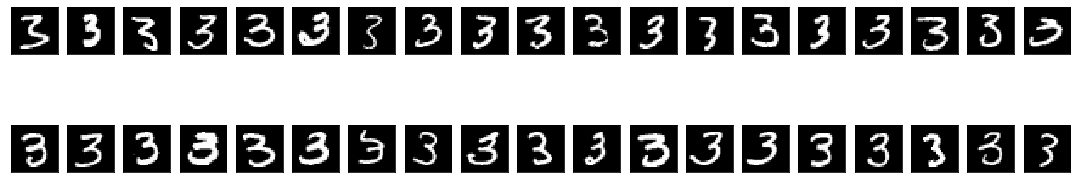

train label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7668177512968204
confusion_matrix:
[[8990    0]
 [1010    0]]


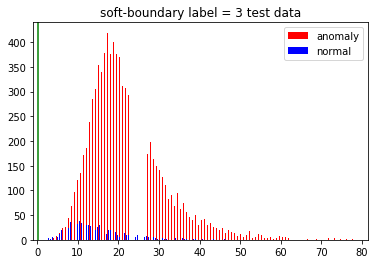

test label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 3 distance oder


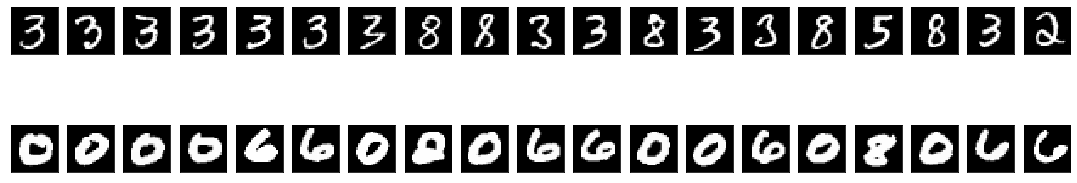

test label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.811991224786181
confusion_matrix:
[[ 474    0]
 [4666    0]]


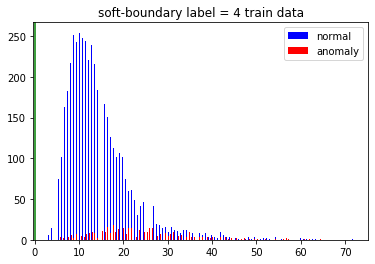

 train label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 4 distance oder


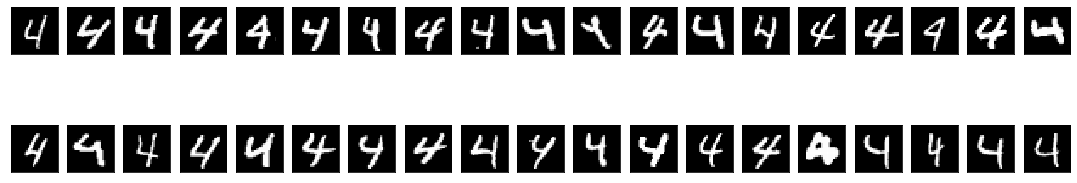

train label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8035109911428557
confusion_matrix:
[[9018    0]
 [ 982    0]]


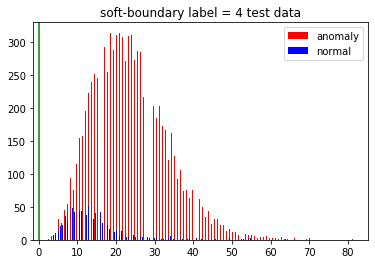

test label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 4 distance oder


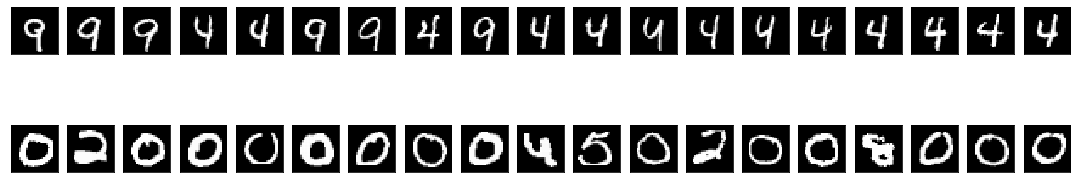

test label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5997608319653931
confusion_matrix:
[[ 429    0]
 [4341    0]]


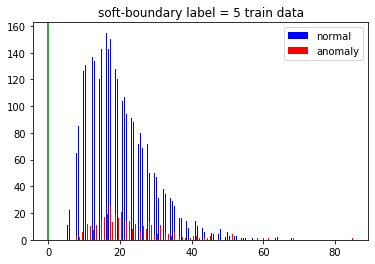

 train label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 5 distance oder


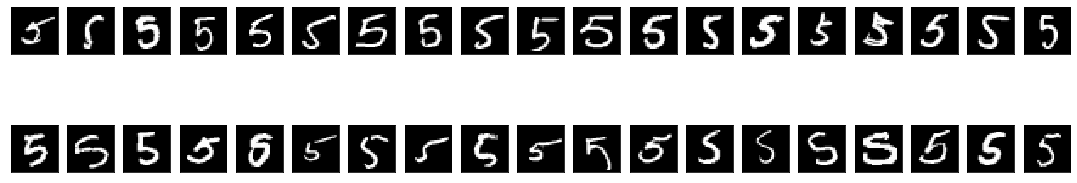

train label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5973372470070168
confusion_matrix:
[[9108    0]
 [ 892    0]]


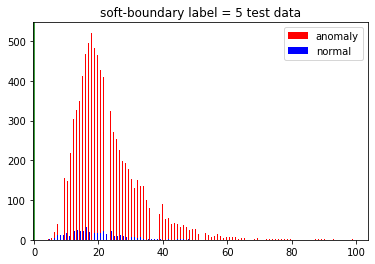

test label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 5 distance oder


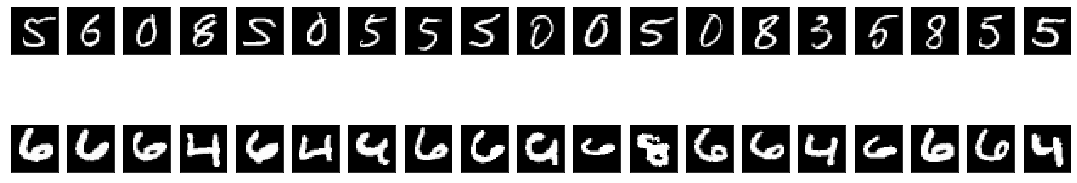

test label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8591195356161312
confusion_matrix:
[[ 473    0]
 [4734    0]]


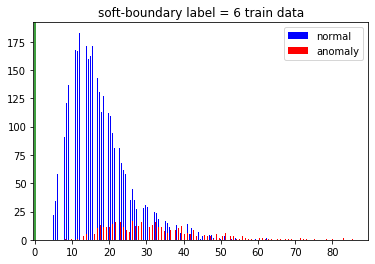

 train label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 6 distance oder


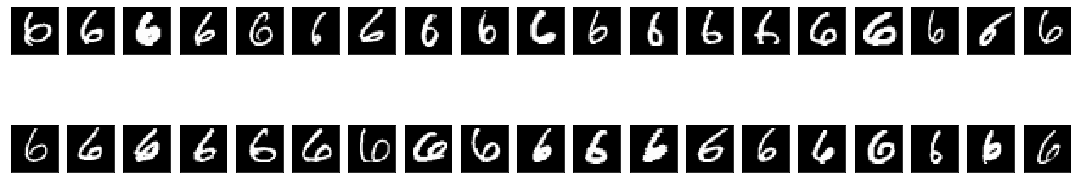

train label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8472852736868401
confusion_matrix:
[[9042    0]
 [ 958    0]]


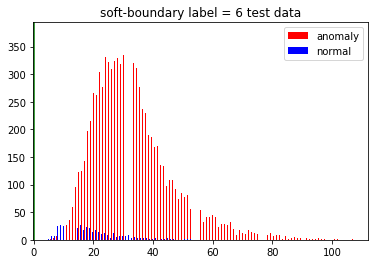

test label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 6 distance oder


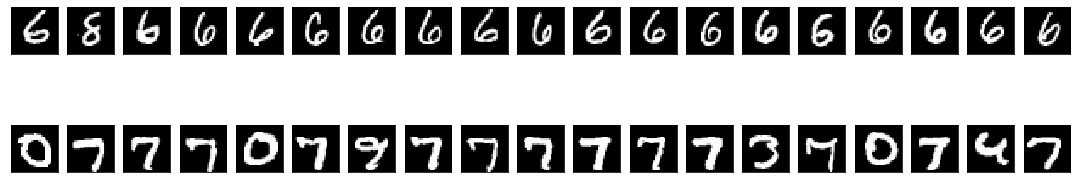

test label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.786022580238321
confusion_matrix:
[[ 514    0]
 [4998    0]]


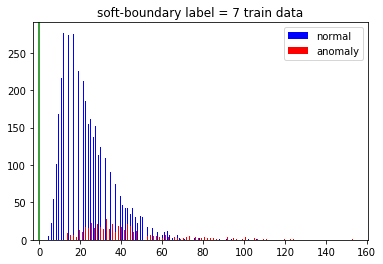

 train label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 7 distance oder


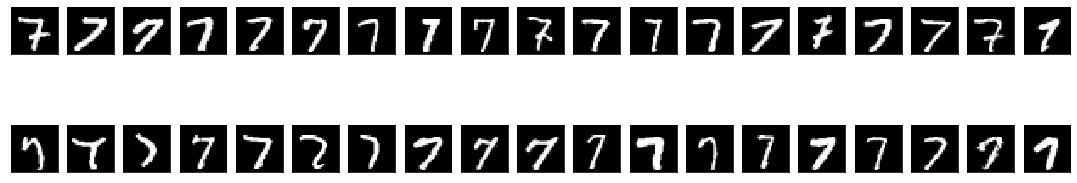

train label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7836354477657252
confusion_matrix:
[[8972    0]
 [1028    0]]


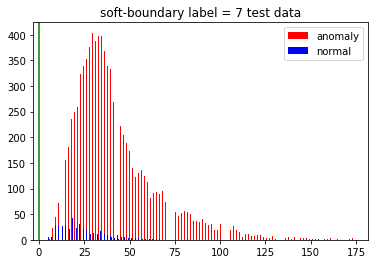

test label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 7 distance oder


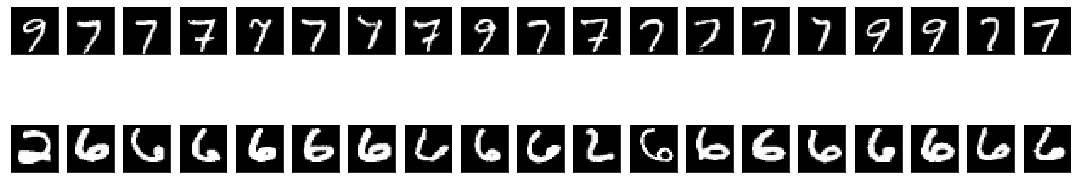

test label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7628253548928285
confusion_matrix:
[[ 477    0]
 [4671    0]]


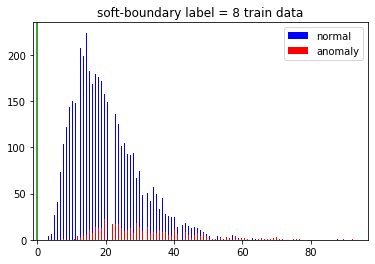

 train label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 8 distance oder


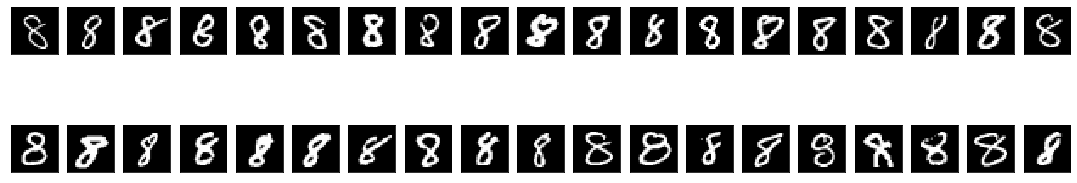

train label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7708634672092622
confusion_matrix:
[[9026    0]
 [ 974    0]]


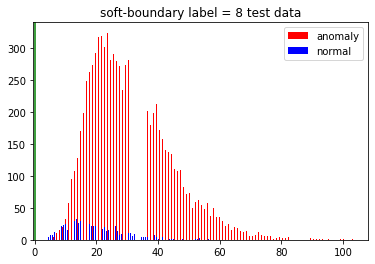

test label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 8 distance oder


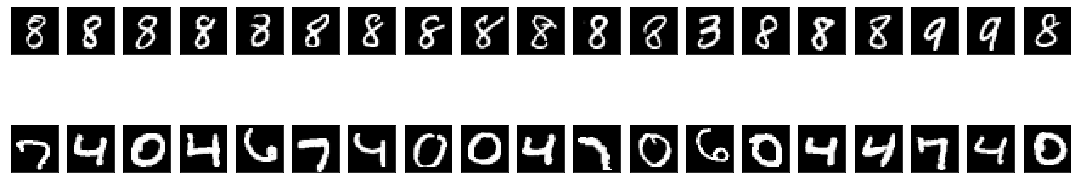

test label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7734199408534009
confusion_matrix:
[[ 500    0]
 [4734    0]]


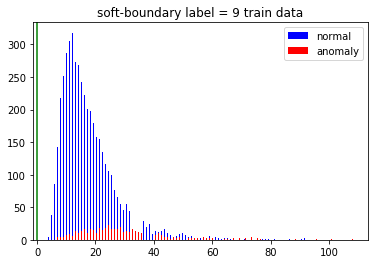

 train label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 9 distance oder


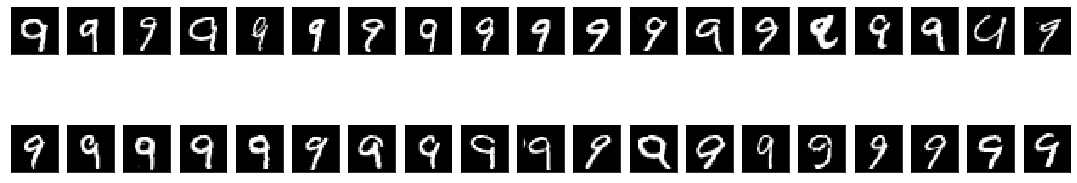

train label = 9 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7983883013064821
confusion_matrix:
[[8991    0]
 [1009    0]]


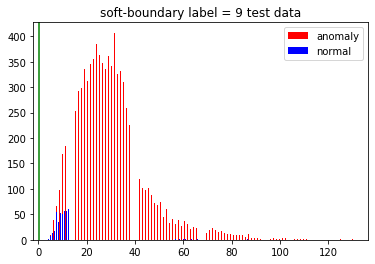

test label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 9 distance oder


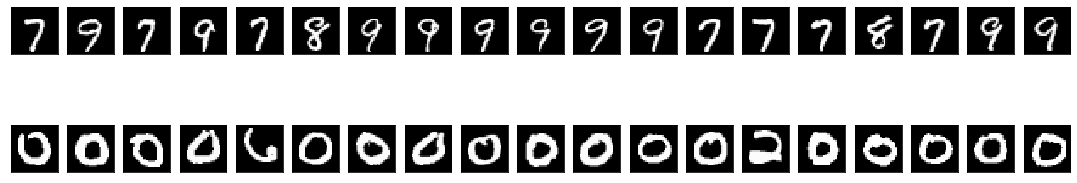

test label = 9 false_img


<Figure size 1440x288 with 0 Axes>

In [19]:
objective = 'soft-boundary'
nu = 0.1
outlier_nu = 0.1
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)



In [20]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [21]:
objective = 'soft-boundary'
nu = 0.2
outlier_nu = 0.2
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)
result

auc =  0.759128750169691
auc =  0.9697776982689437
auc =  0.6581823118720135
auc =  0.7201968634015793
auc =  0.7531269210842855
auc =  0.7010624622122965
auc =  0.8459561711317954
auc =  0.8252201835021536
auc =  0.7769383769725698
auc =  0.8425515042627696


array([[ 0.        ,  0.        ,  0.75912875, 77.6891973 ],
       [ 1.        ,  0.        ,  0.9697777 , 87.01727986],
       [ 2.        ,  0.        ,  0.65818231, 78.26884556],
       [ 3.        ,  0.        ,  0.72019686, 79.11392331],
       [ 4.        ,  0.        ,  0.75312692, 75.45803547],
       [ 5.        ,  0.        ,  0.70106246, 71.42739034],
       [ 6.        ,  0.        ,  0.84595617, 79.48646688],
       [ 7.        ,  0.        ,  0.82522018, 83.85826516],
       [ 8.        ,  0.        ,  0.77693838, 75.60156226],
       [ 9.        ,  0.        ,  0.8425515 , 67.68986082]])

AUC: 0.8841381790305535
confusion_matrix:
[[ 943    0]
 [4742    0]]


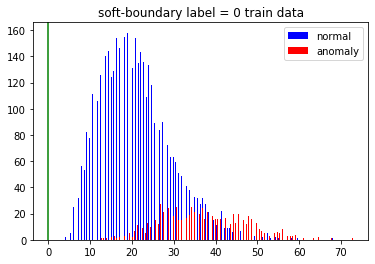

 train label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 0 distance oder


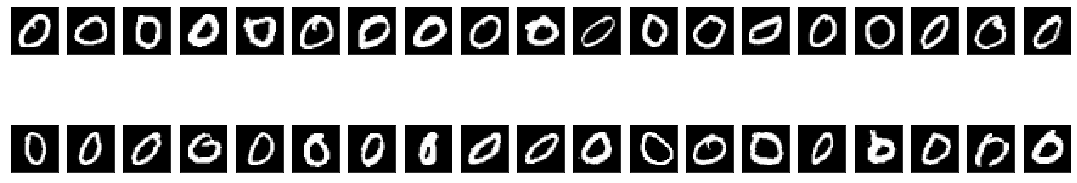

train label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8830715190732613
confusion_matrix:
[[9020    0]
 [ 980    0]]


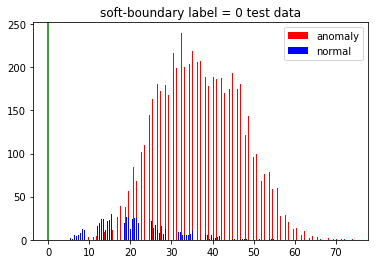

test label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 0 distance oder


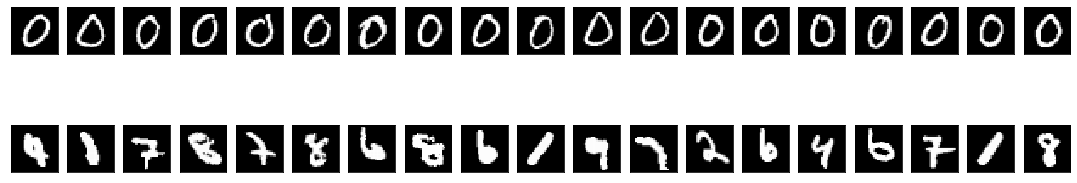

test label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8618439998236337
confusion_matrix:
[[1076    0]
 [5396    0]]


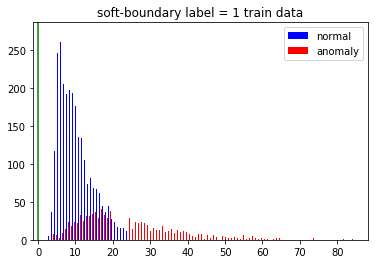

 train label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 1 distance oder


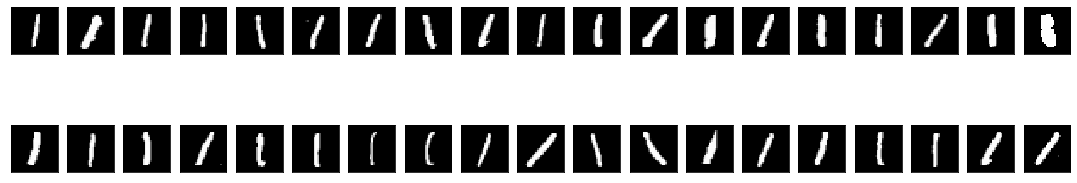

train label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8791149175965473
confusion_matrix:
[[8865    0]
 [1135    0]]


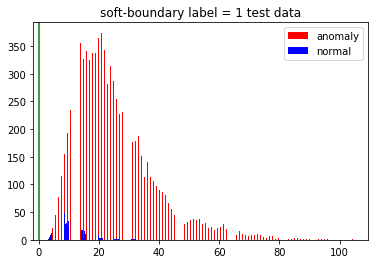

test label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 1 distance oder


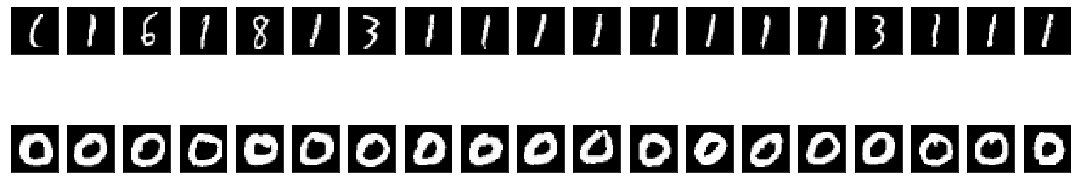

test label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.6764364121562364
confusion_matrix:
[[ 949    0]
 [4770    0]]


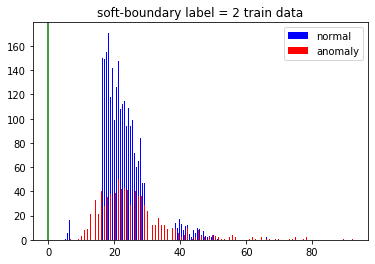

 train label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 2 distance oder


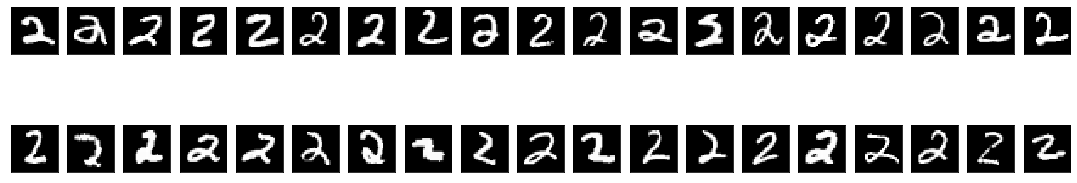

train label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.6897222099765574
confusion_matrix:
[[8968    0]
 [1032    0]]


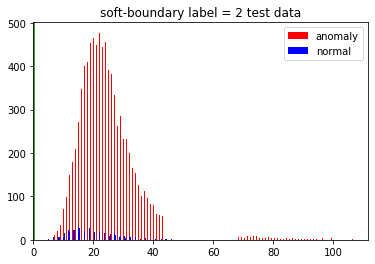

test label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 2 distance oder


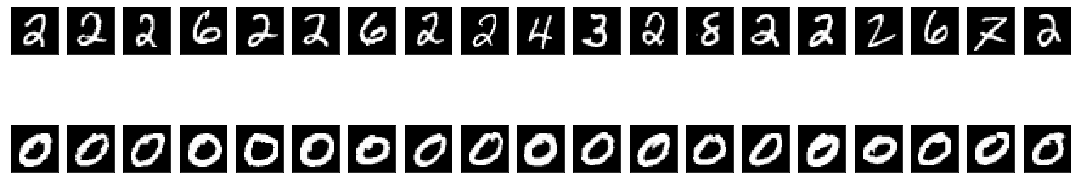

test label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7293330420853358
confusion_matrix:
[[ 980    0]
 [4905    0]]


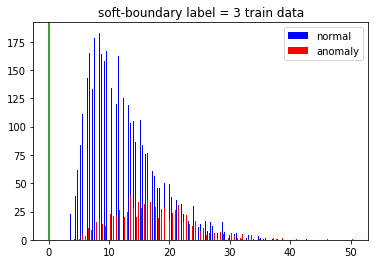

 train label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 3 distance oder


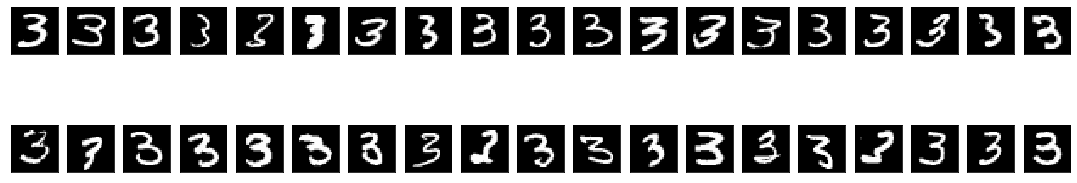

train label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7431455742904658
confusion_matrix:
[[8990    0]
 [1010    0]]


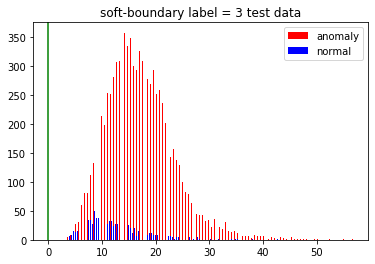

test label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 3 distance oder


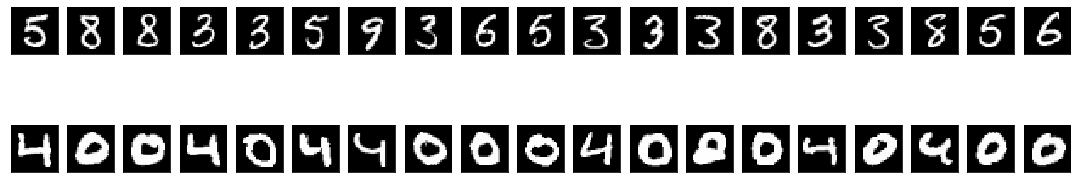

test label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7412571332202956
confusion_matrix:
[[ 940    0]
 [4668    0]]


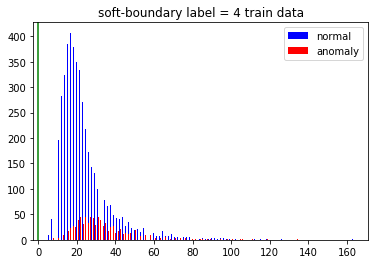

 train label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 4 distance oder


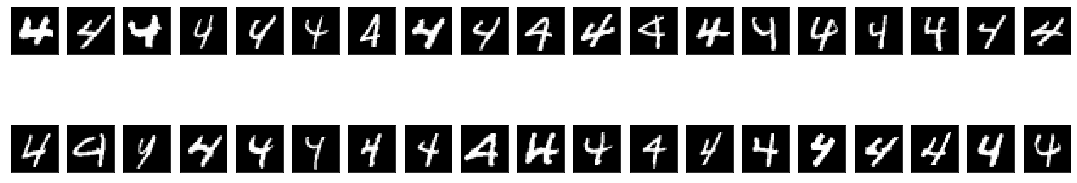

train label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7339841701525665
confusion_matrix:
[[9018    0]
 [ 982    0]]


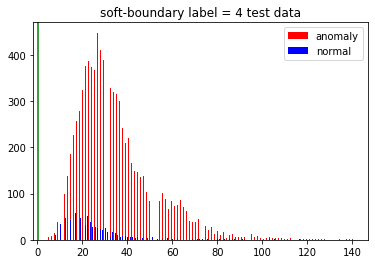

test label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 4 distance oder


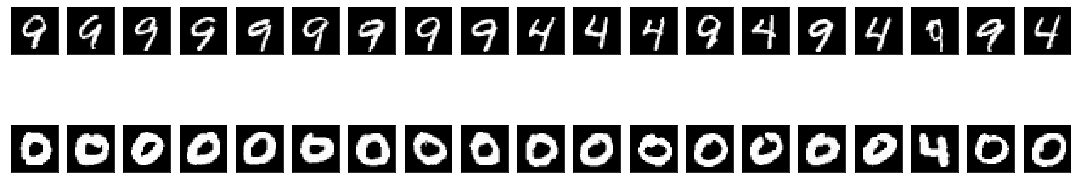

test label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.58119009334614
confusion_matrix:
[[ 865    0]
 [4339    0]]


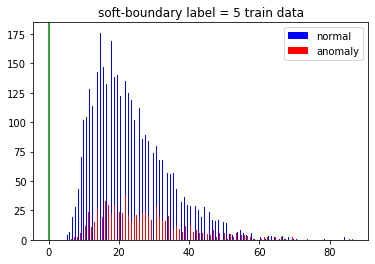

 train label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 5 distance oder


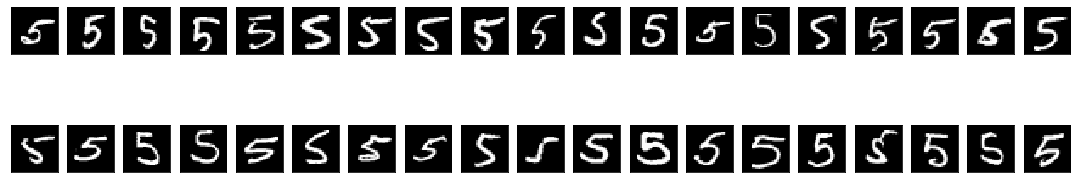

train label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5694523835547914
confusion_matrix:
[[9108    0]
 [ 892    0]]


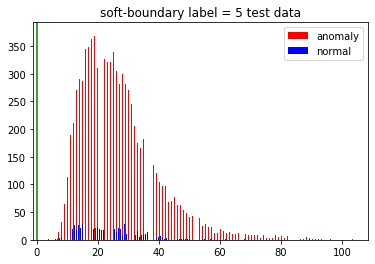

test label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 5 distance oder


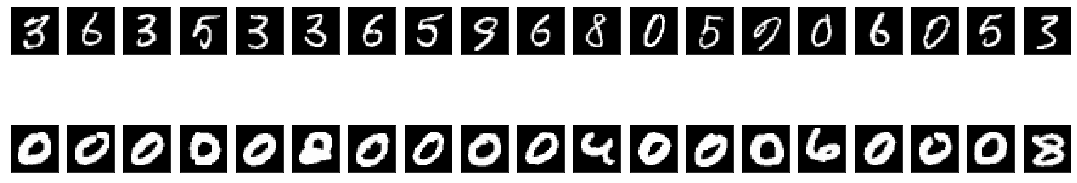

test label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8480069548049949
confusion_matrix:
[[ 963    0]
 [4717    0]]


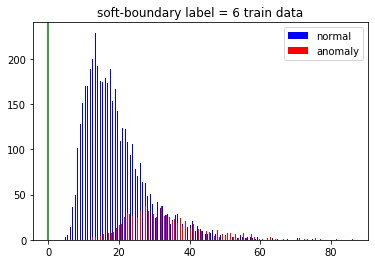

 train label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 6 distance oder


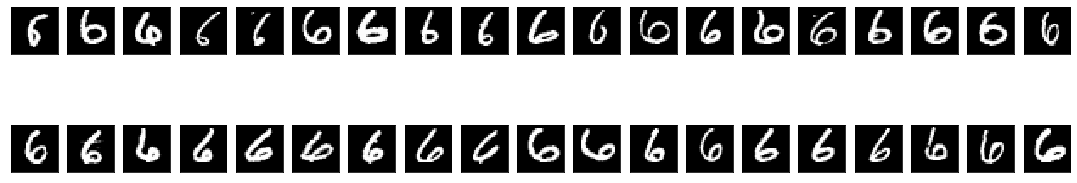

train label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8140384307238915
confusion_matrix:
[[9042    0]
 [ 958    0]]


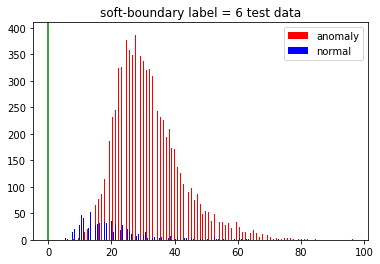

test label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 6 distance oder


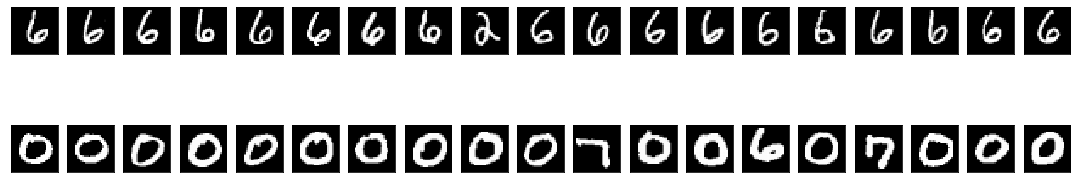

test label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.776373837816652
confusion_matrix:
[[1012    0]
 [5002    0]]


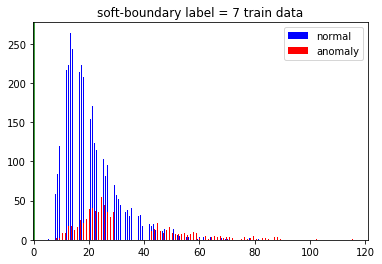

 train label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 7 distance oder


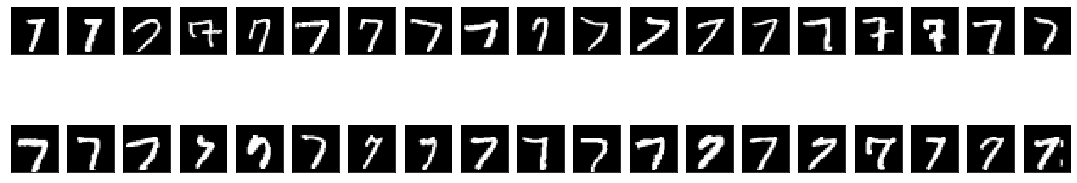

train label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7763499195942066
confusion_matrix:
[[8972    0]
 [1028    0]]


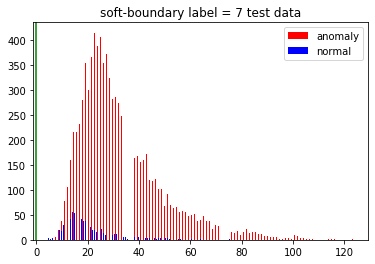

test label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 7 distance oder


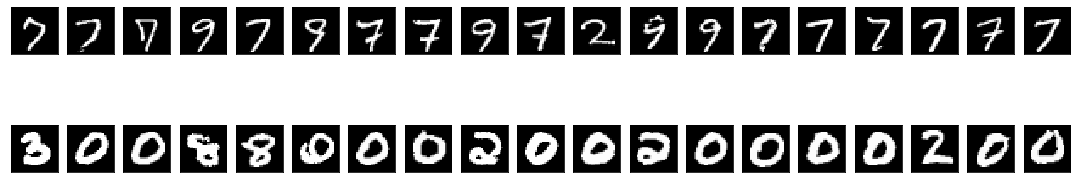

test label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7391143597951562
confusion_matrix:
[[ 945    0]
 [4671    0]]


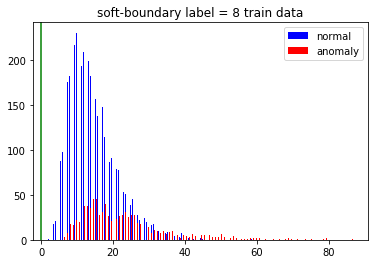

 train label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 8 distance oder


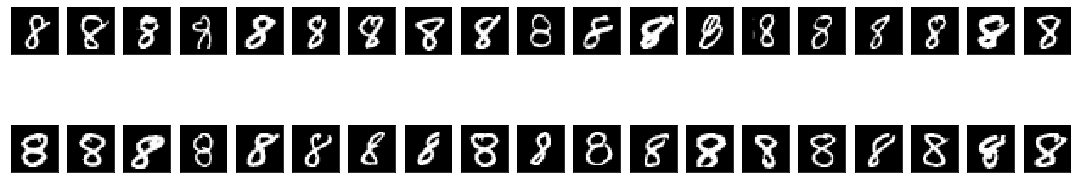

train label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7440436730576646
confusion_matrix:
[[9026    0]
 [ 974    0]]


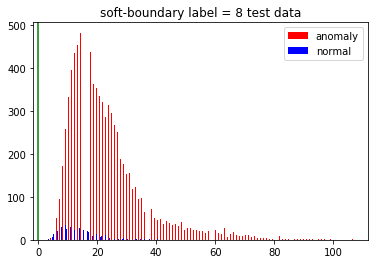

test label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 8 distance oder


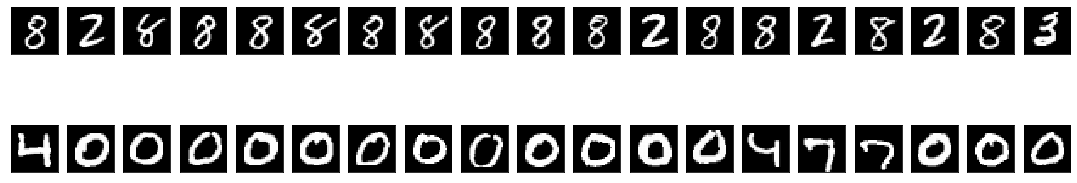

test label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.813329064483278
confusion_matrix:
[[ 951    0]
 [4759    0]]


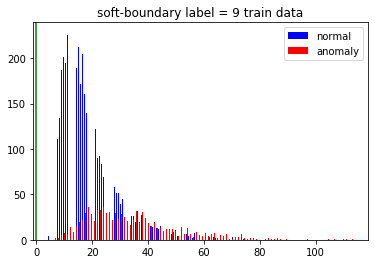

 train label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 9 distance oder


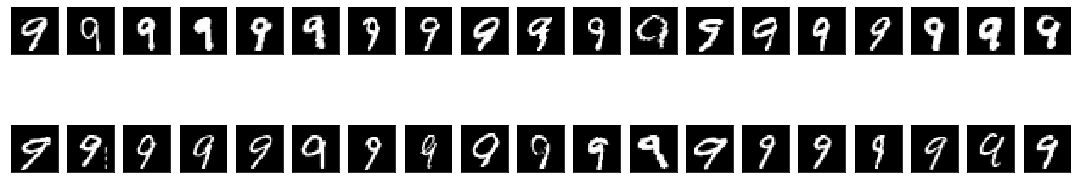

train label = 9 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8335862015522846
confusion_matrix:
[[8991    0]
 [1009    0]]


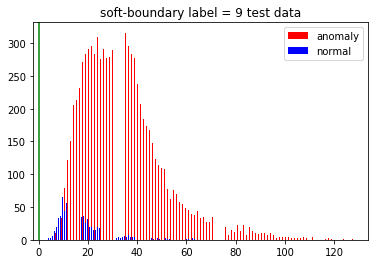

test label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 9 distance oder


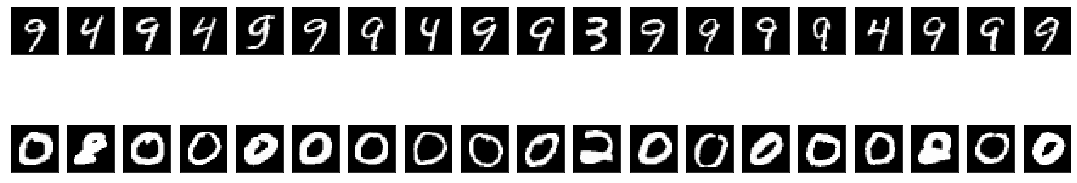

test label = 9 false_img


<Figure size 1440x288 with 0 Axes>

In [22]:
objective = 'soft-boundary'
nu = 0.2
outlier_nu = 0.2
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)



In [23]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

In [24]:
objective = 'soft-boundary'
nu = 0.3
outlier_nu = 0.3
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    pre_time = time.time()
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    ae.train_ae(150, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder, train_dataset = train_dataset)
    SVDD.train(x_novali, n_epochs = 150)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    
    confusionmatrix_test_list.append(confusiontest)
    confusionmatrix_train_list.append(confusiontrain)
result

auc =  0.7815234286619304
auc =  0.9573169743907013
auc =  0.6537029917743707
auc =  0.7258158129494818
auc =  0.7642932058489945
auc =  0.6729893372209126
auc =  0.7912209387968647
auc =  0.7704313224367726
auc =  0.7451734232522882
auc =  0.8453504159373556


array([[ 0.        ,  0.        ,  0.78152343, 73.96354532],
       [ 1.        ,  0.        ,  0.95731697, 86.78884363],
       [ 2.        ,  0.        ,  0.65370299, 79.26575303],
       [ 3.        ,  0.        ,  0.72581581, 81.74917626],
       [ 4.        ,  0.        ,  0.76429321, 73.62263083],
       [ 5.        ,  0.        ,  0.67298934, 67.16544318],
       [ 6.        ,  0.        ,  0.79122094, 70.32398891],
       [ 7.        ,  0.        ,  0.77043132, 75.05831409],
       [ 8.        ,  0.        ,  0.74517342, 69.3682394 ],
       [ 9.        ,  0.        ,  0.84535042, 68.75922394]])

AUC: 0.8109634656365431
confusion_matrix:
[[1416    0]
 [4743    0]]


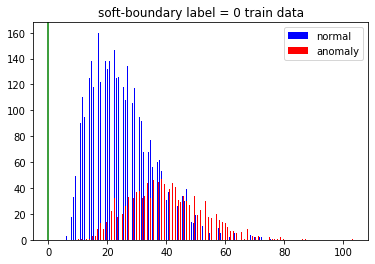

 train label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 0 distance oder


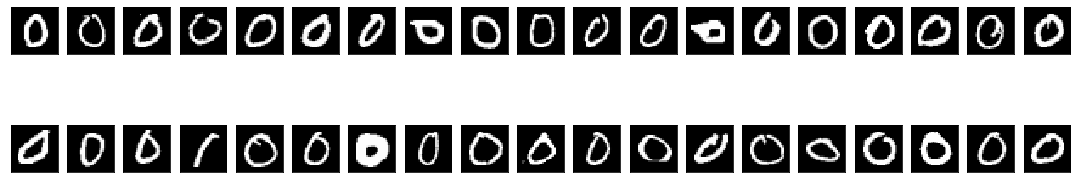

train label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8160682610072854
confusion_matrix:
[[9020    0]
 [ 980    0]]


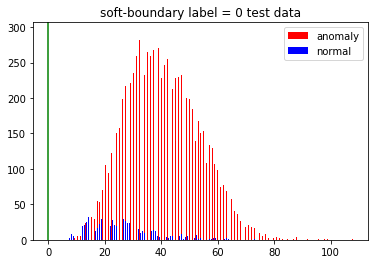

test label = 0 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 0 distance oder


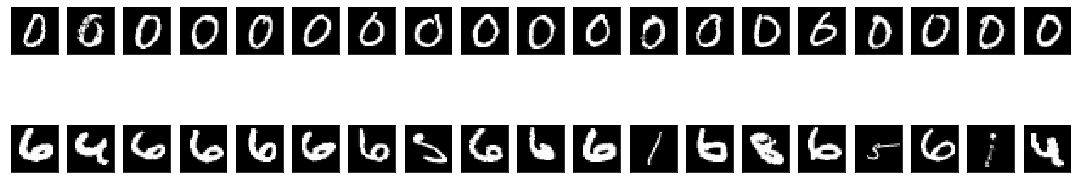

test label = 0 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8612305349221487
confusion_matrix:
[[1624    0]
 [5387    0]]


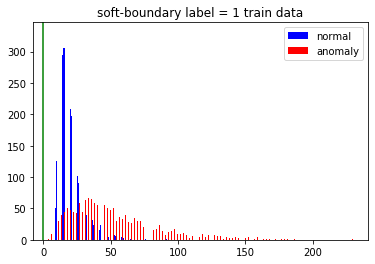

 train label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 1 distance oder


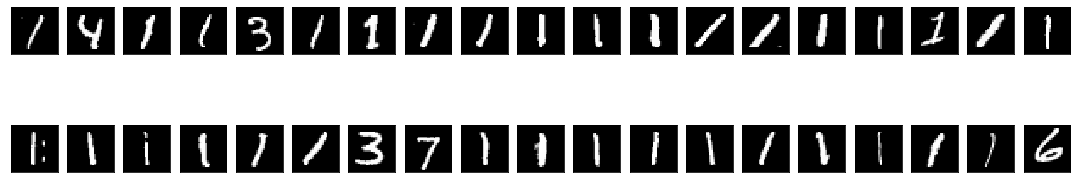

train label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8731211938251452
confusion_matrix:
[[8865    0]
 [1135    0]]


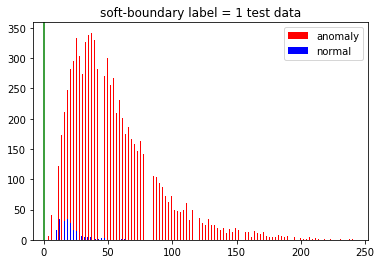

test label = 1 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 1 distance oder


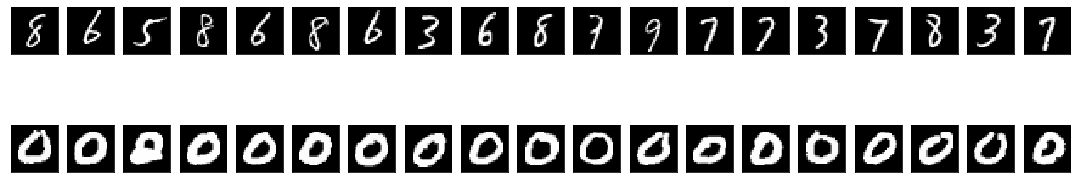

test label = 1 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.667518446605339
confusion_matrix:
[[1443    0]
 [4753    0]]


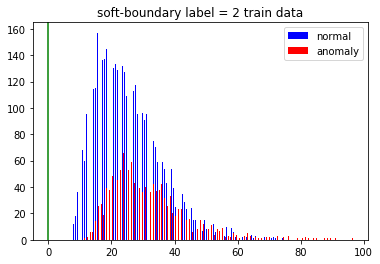

 train label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 2 distance oder


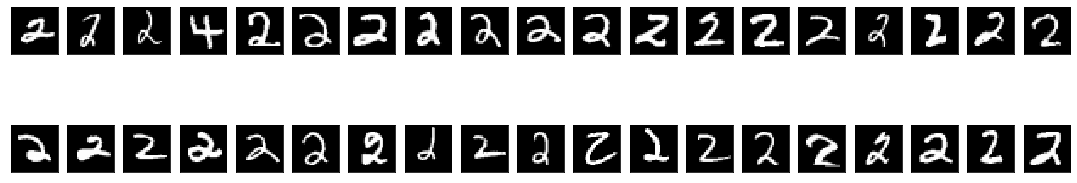

train label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.6817011194842645
confusion_matrix:
[[8968    0]
 [1032    0]]


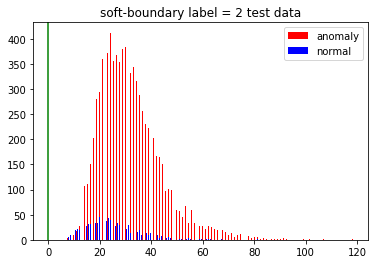

test label = 2 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 2 distance oder


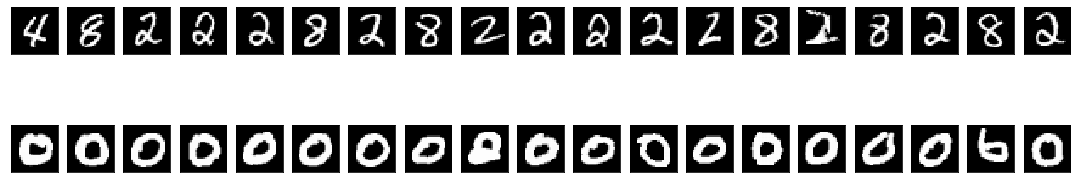

test label = 2 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7231537603780251
confusion_matrix:
[[1480    0]
 [4896    0]]


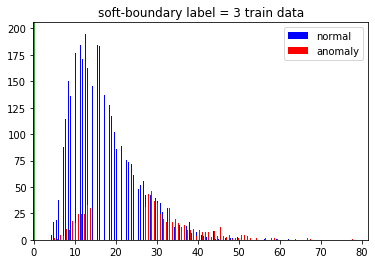

 train label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 3 distance oder


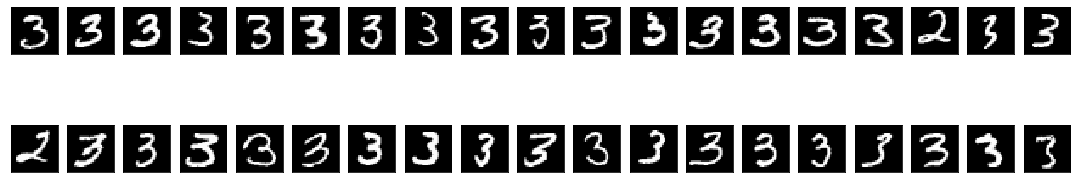

train label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7566618575094438
confusion_matrix:
[[8990    0]
 [1010    0]]


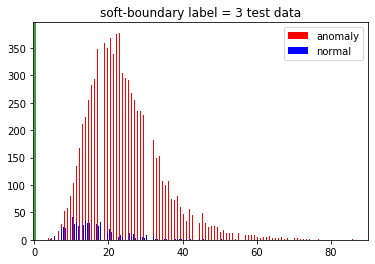

test label = 3 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 3 distance oder


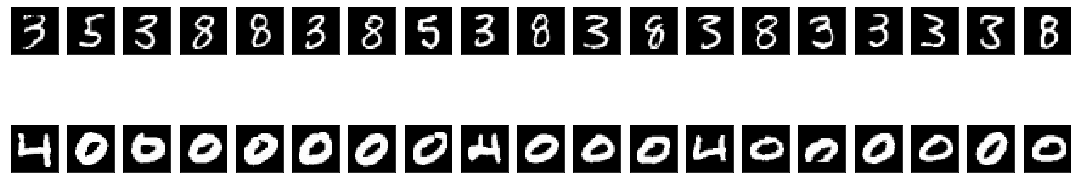

test label = 3 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7507183827857233
confusion_matrix:
[[1426    0]
 [4649    0]]


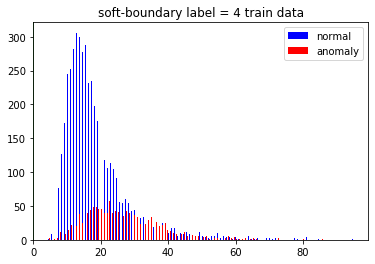

 train label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 4 distance oder


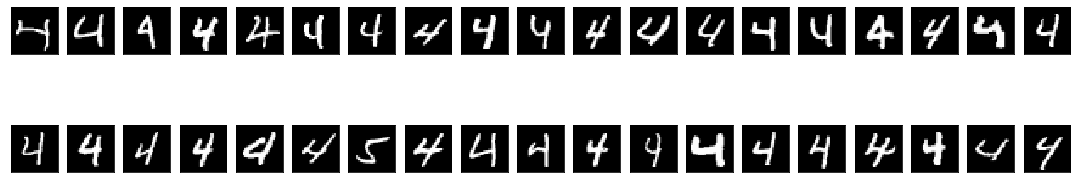

train label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7527558596317209
confusion_matrix:
[[9018    0]
 [ 982    0]]


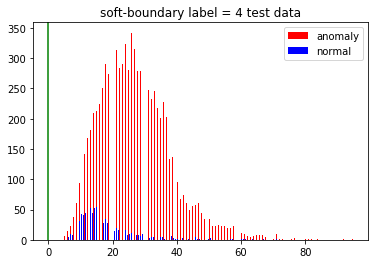

test label = 4 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 4 distance oder


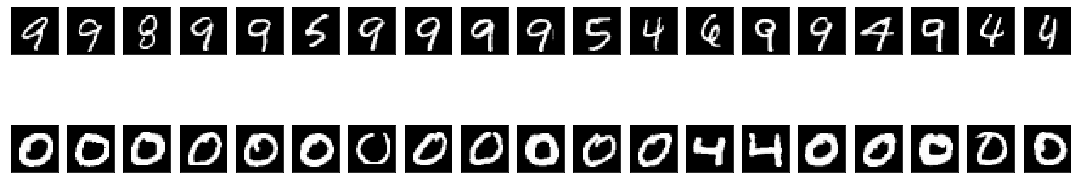

test label = 4 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5919349708710072
confusion_matrix:
[[1307    0]
 [4330    0]]


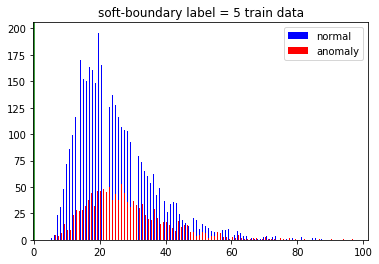

 train label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 5 distance oder


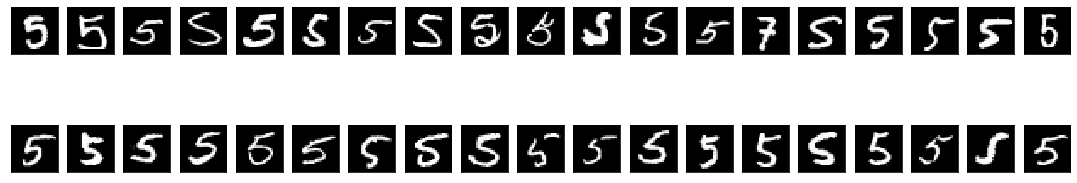

train label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.5850101472908062
confusion_matrix:
[[9108    0]
 [ 892    0]]


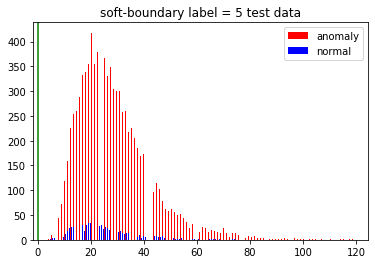

test label = 5 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 5 distance oder


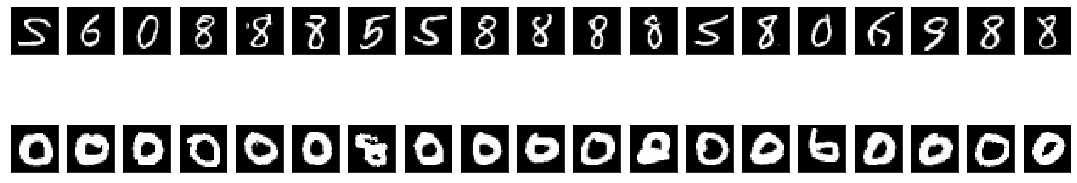

test label = 5 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7747969199183184
confusion_matrix:
[[1439    0]
 [4715    0]]


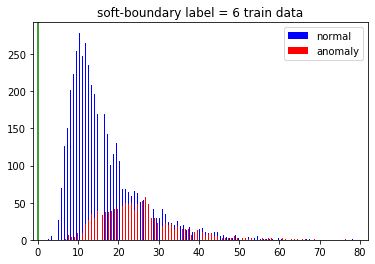

 train label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 6 distance oder


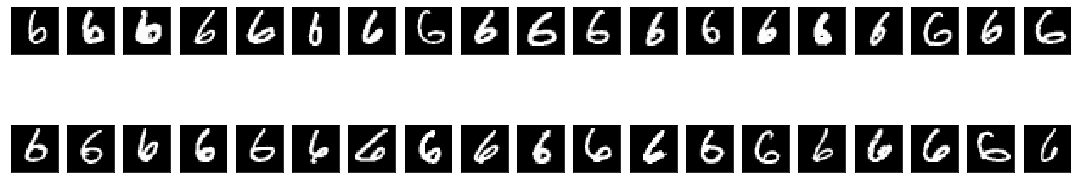

train label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7292065235812093
confusion_matrix:
[[9042    0]
 [ 958    0]]


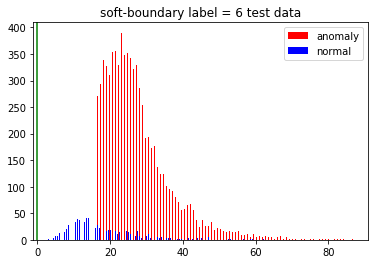

test label = 6 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 6 distance oder


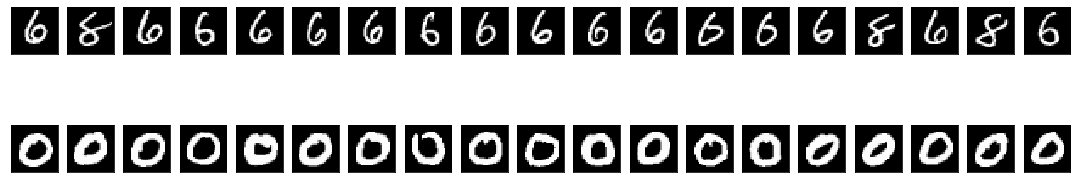

test label = 6 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7544319522902239
confusion_matrix:
[[1502    0]
 [5013    0]]


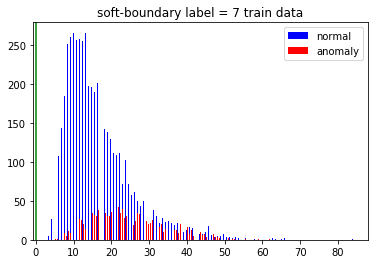

 train label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 7 distance oder


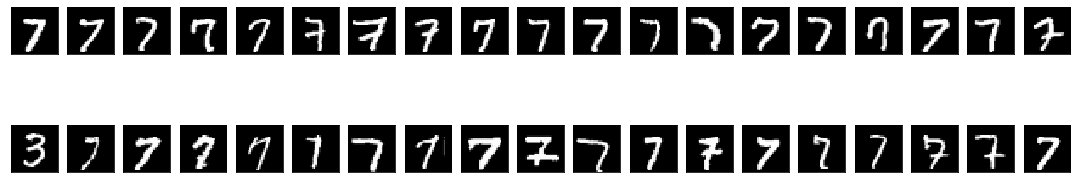

train label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.7465169415960765
confusion_matrix:
[[8972    0]
 [1028    0]]


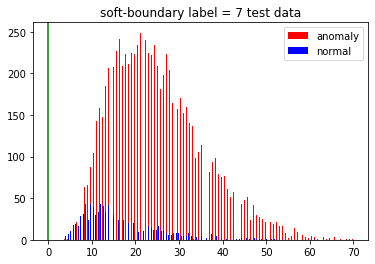

test label = 7 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 7 distance oder


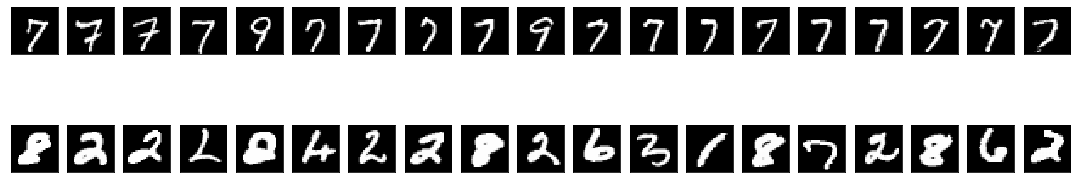

test label = 7 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8112630000880077
confusion_matrix:
[[1410    0]
 [4674    0]]


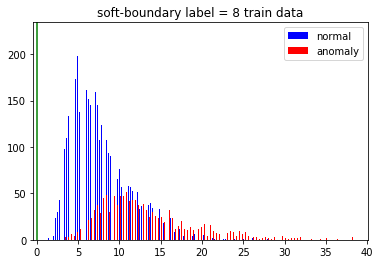

 train label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 8 distance oder


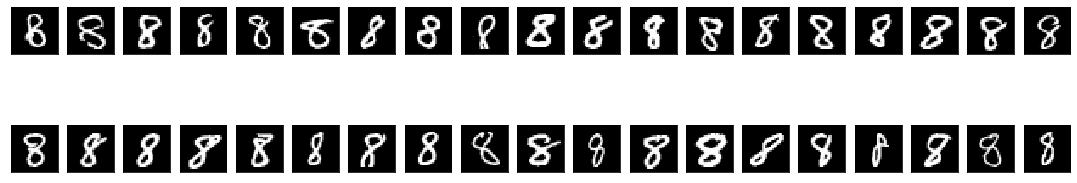

train label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8310449029065476
confusion_matrix:
[[9026    0]
 [ 974    0]]


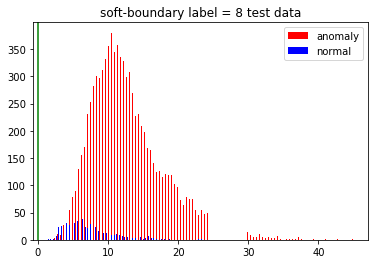

test label = 8 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 8 distance oder


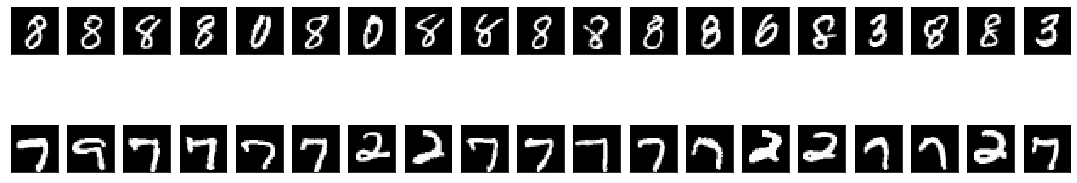

test label = 8 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8131729813500208
confusion_matrix:
[[1430    0]
 [4756    0]]


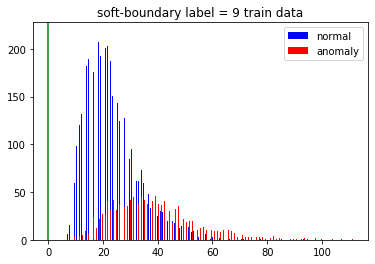

 train label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

train label = 9 distance oder


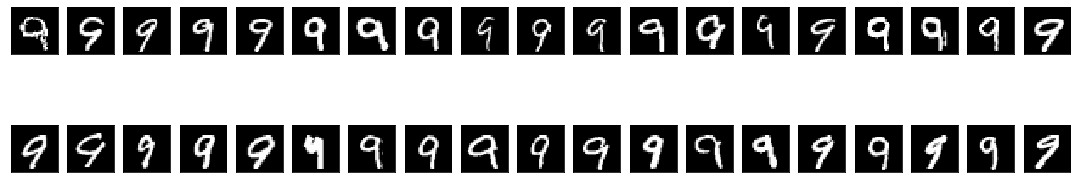

train label = 9 false_img


<Figure size 1440x288 with 0 Axes>

AUC: 0.8170047042968528
confusion_matrix:
[[8991    0]
 [1009    0]]


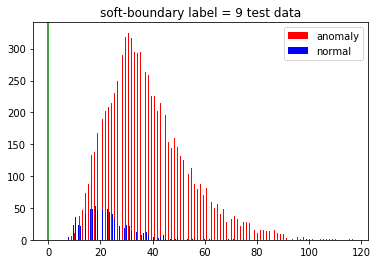

test label = 9 uncertain_img


<Figure size 1440x288 with 0 Axes>

test label = 9 distance oder


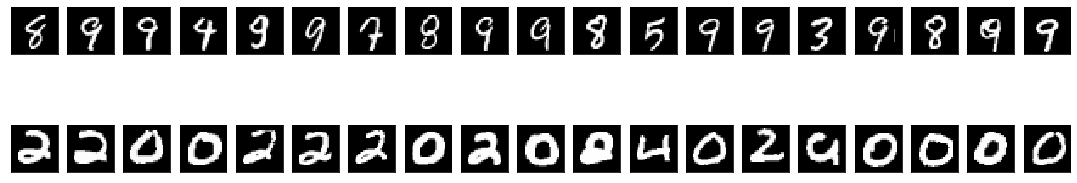

test label = 9 false_img


<Figure size 1440x288 with 0 Axes>

In [25]:
objective = 'soft-boundary'
nu = 0.3
outlier_nu = 0.3
for label_num in np.arange(10):
    ## 資料設定
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ## 訓練 autoencoder
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(nu = nu, label_num = label_num , objective = objective, encoder = encoder
                      , train_dataset = train_dataset)
    radius_end, train_auc, confusiontrain = SVDD.train_result(x_novali, y_novali, show_img = True)
    test_auc, confusiontest  = SVDD.test(x_test, y_test, radius_end, show_img = True)

